# 19장 설명 가능한 딥러닝 모델 만들기

## 설명 가능한 딥러닝의 <br />
현업에서 예측의 결과를 설명해야 할 경우가 있다. 예를 들어 치매 환자가 있을 때 왜? 어느 부분 때문에? 라는 예측에 대한 결과를 설명해야 하는 경우 가 있을 것이다.<br />
이러한 경우에 필요한 딥너링 알고리즘이다.<br />

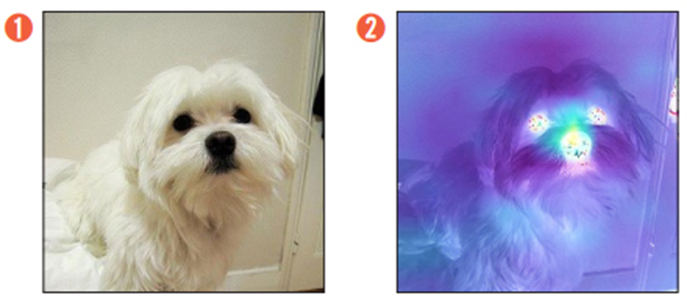<br />
-이미지를 사용해 이름이나 물건의 종류를 맞히는 모델을 만들었다면<br />
-이미지의 어디를 보고 왜 그런 판단을 했는지 설명해 내는 또 다른 그림을 그려 내는 것이 필요하다.<br />
-두번째 이미지에서 밝은 부분이 말티즈의 특징을 나타내는 것이다. 즉 색이 밝을수록 예측에 많은 기여를 했다는 것이고 파란색에 가까울수록 기여가 적다

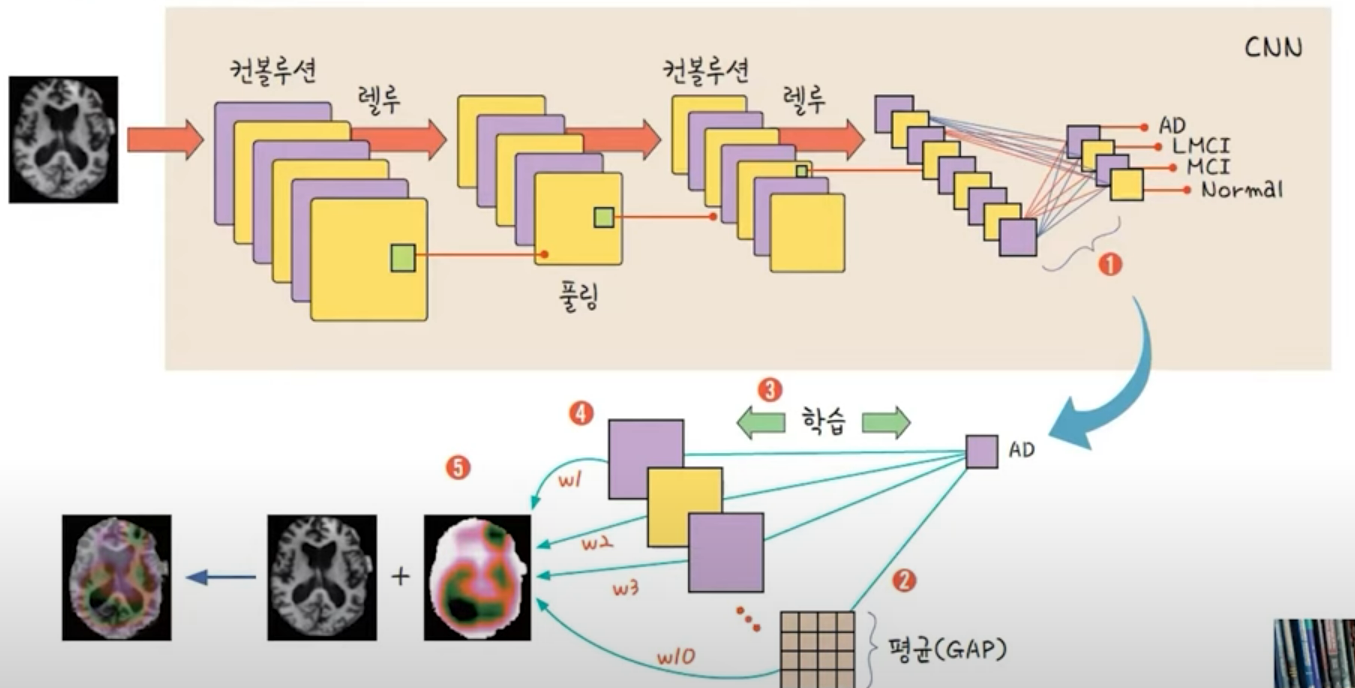 <br />
여러 가지의 알고리즘 중에 첫 번째로 GAN이라는 알고리즘을 가져온 것인다. CNN은 컴볼류셩을 거치면서 특징을 뽑아내는 것이다. 이는 컴볼루션 레이어를 거치면서 특징을 뽑는 것인데 마지막 층을 거치면서 그 특징이 뚜렷해진다는 것을 착안해서 최종단계로 가기전에 뽑아와서 평균값을 내고 그것을 이용해서 학습한 후 주요한 역할을 한 맴에 따라 가중치를 주고 가중치에 따라 가중치가 적으면 밝에 가중치가 높으면 진하게 표시를 해주면서 실제 치매환자사진과 겹쳐 보여주면서 어디가 치매에 중요한 요소인지를 알려줄 수 있게 해준다.
어떠한 부부닝 중요한 역할을 했느지 알려주는 역할을 하는 것이 CAM이다. 

In [ ]:
딥러닝의 중간 과정에서 나온 특징 맵을 이용하는 방법<br />
이러한 방법의 대표적인 사례가 CAM(Class Activation Map) <br />
풀링을 하는 이유는 무엇일까? 2차원의 데이터를 1차원으로 변경하기 위해서는 크기가 작을 수록 좋기 때문이다.<br />
차원을 줄이는 과정에서 공간의 손실이 발생할 수밖에 없다는 것은 입력 데이터의 속성을 잘 간직하고 있다는 것이다.<br />
CAM은 여기서 아이디어를 얻었음<br />
이 데이터를 1차원으로 축소시키는 Flatten 단계 직전에 개입해서 그때까지 만들어진 중간 맵들을 따로 모음<br />
얻은 맵의 평균값과 최종 예측 사이에서 한 번 더 학습하고 중간맵을 가중하여 불 필요한 맵을 없앤다.

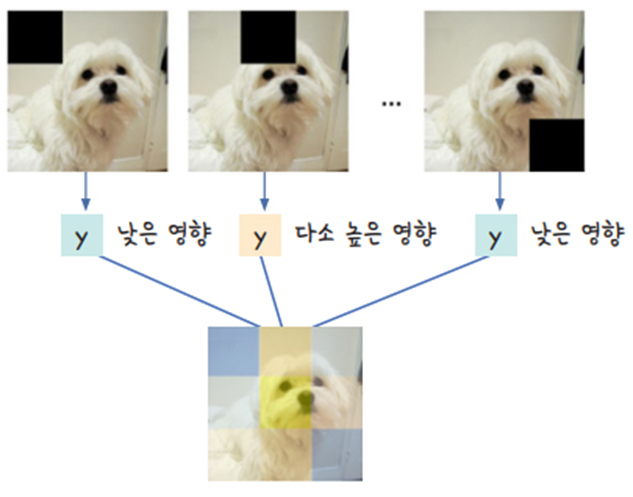<br />
-두번째 방법은 오클루전 알고리즘방식이다.<br />
-위 말티즈 그림 처럼 일정한 영역을 가리면서 중요한 부분을 찾아낸다<br />
-영향력이 클 수록 밝은색으로 나타나게 하는 방식<br />
-이를 마스크 방식 또는 오클루전(폐쇄성 민감도(Occlusion Sensitivity)) 방식이라고 함<br />
-그레이디언트 CAM 방식, 오클루전 방식이 있다.

In [1]:
!pip install tf-explain # 위 두가지 방식을 사용하게 해주는 라이브러리이다,

In [2]:
!pip install opencv-python # 이미지 및 비디오 처리 기능

In [ ]:
!git clone https://github.com/SoongMoo/data.git

In [ ]:
# 딥러닝을 하기 전에 어떠한 임지를 사용할 것인지 먼저 불러와 보

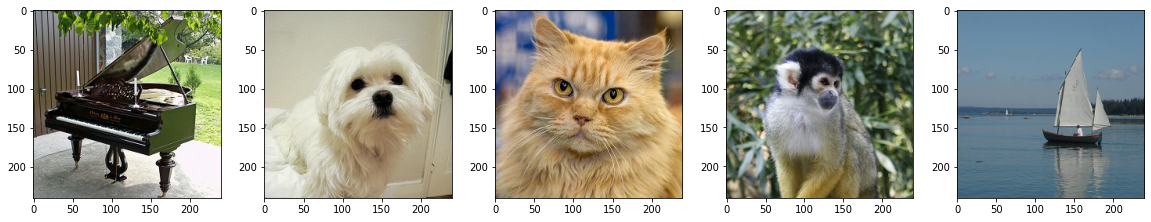

In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI알고리즘을 불러오는 부분입니다.
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 원본 이미지가 들어갈 리스트 만들기
images_originals = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣기
for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

# 주피터 노트북 상에서 보여질 이미지의 크기 
plt.figure(figsize=(20,20))

# 원본 이미지를 주피터 노트북에서 보이게 하기
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1) # plt.subplot(nrows, ncols, index) nrows:세로로 나열되는 플롯 수, ncols:로로 나열되는 플롯 수, index:현재 위치한 플롯의 인덱스
    plt.imshow(image_o)

553476096/553467096 [==============================] - 61s 0us/step


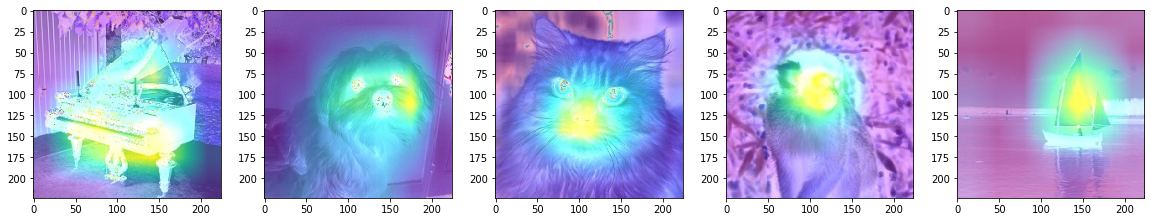

In [4]:
# 사전에 학습된 딥러닝 모델 불러오기
model = VGG16(weights="imagenet", include_top=True)

# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]


# 여기서부터가 우리하려는 딥러닝부분이다.
# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()    # 그레이디언트 CAM알고리즘 선택

# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_cams = []

# 그레이디언트 CAM 알고리즘 실행
# 가지고 있는 이미지를 불러온다.
for l, i in zip(input_list, imagenet_index):   
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224)) # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정합니다. 
    img = img_to_array(img) # 이미지를 넘파이 배열로 바꾸어 줍니다.
    data = ([img], None)
# 이미지 불러오기 끝
                                        # int(i) : index로 이미지를 불러와 model과 비교하도록 만들어 준다,
                                        #          data와 model을 비교할 때 사용되는 class
 # output=explainer.explain(데이터, 모델, 클래스)
    grid = explainer.explain(data, model, int(i), layer_name="block5_conv3") # 그레이디언트 CAM이 실행되는 부분입니다. 
                                                  # layer_name="block5_conv3는 생략 가능 
                                                  # block5_conv3는 CNN 모델, 특히 VGG 모델에서 5번째 블록의 3번째 합성곱 레이어를 사용한다는 의미
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l))# 실행 후 저장되는 이름입니다. 
                                        # explainer.save(output, 저장폴더, 저장될 이름)
                                        
# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

두 개의 리스트 또는 튜플을 요소별로 묶는 함수
input_list = ['cat', 'dog', 'bird']
imagenet_index = [0, 1, 2]

zipped = zip(input_list, imagenet_index)
for item in zipped:
    print(item)


('cat', 0)
('dog', 1)
('bird', 2)

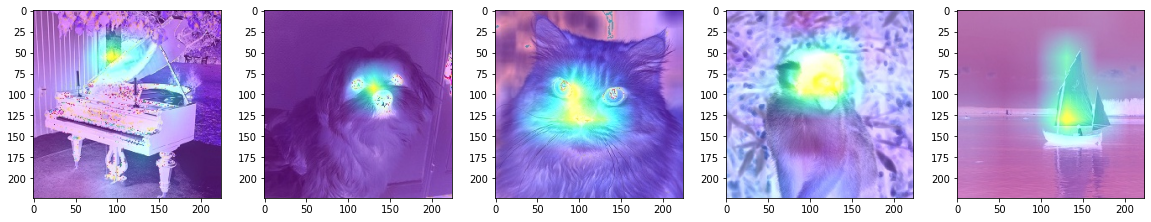

In [5]:
# 오클루전 알고리즘을 불러와 실행합니다.

explainer = OcclusionSensitivity() #이미지 기반 모델에서 특정 부분이 모델의 예측에 얼마나 영향을 미치는지를 확인하는 데 사용
                                   #이미지에서 일부 영역을 가려서 모델의 예측 변화를 관찰, 어떤 특징에 주로 의존하는지 판단
# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 사이즈를 정합니다. 
patch_size = 40 # 이미지에서 일부분을 가릴 때, 그 부분의 크기를 결정 , 마스크부분을 40으로 

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) #패치 사이즈의 설정이 추가됩니다. patch_size는 마스크의 크기가 된다.
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

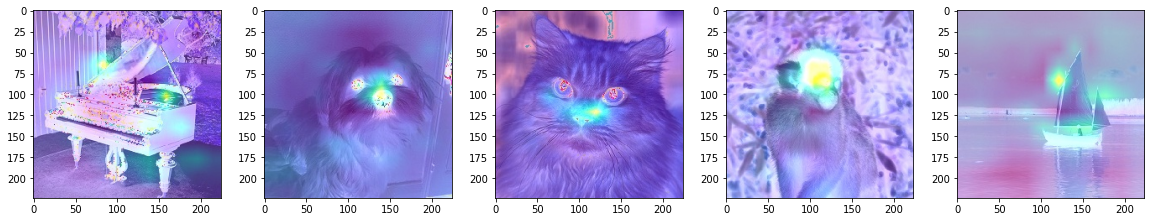

In [6]:
patch_size = 20 # 마스크를 20으로 주여봄

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) 
    explainer.save(grid, ".", './data/img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('./data/img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)


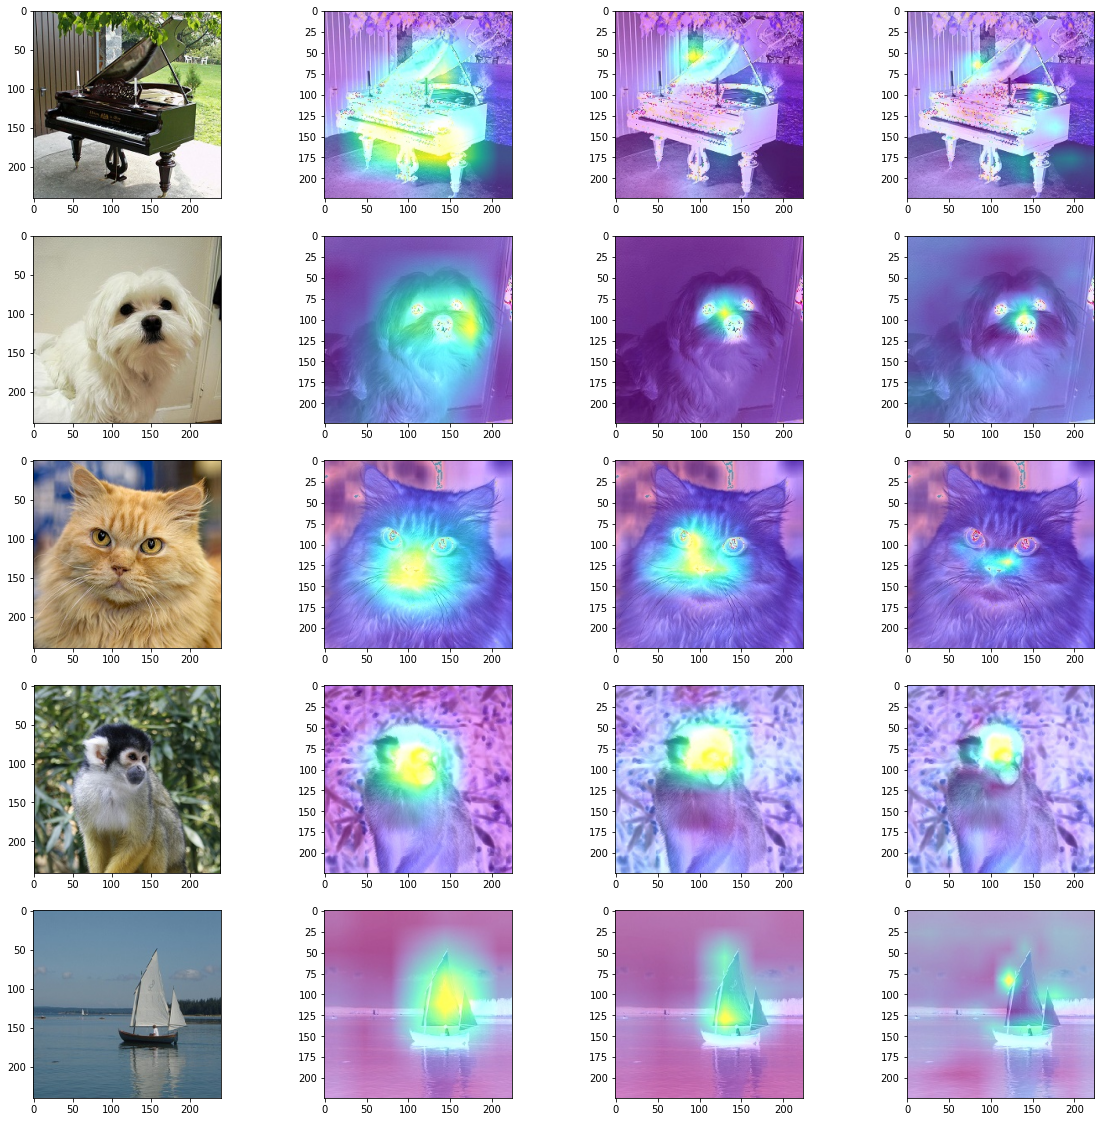

In [7]:
# 전체 이미지 한 눈에 보기.

plt.figure(figsize=(20,20))

images = []
for img_path in glob.glob('./data/img/*.jpg'):
    images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)